In [1]:
#!pip install gensim

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import bz2

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
!python ./src/load_models_data.py

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Load Data

## Quotes

In [4]:
data_folder = './data/'
data_file = 'quotes-sample.json.bz2'
data_path = data_folder + data_file
chunk_size = 1e4

# Load 1 chunk
#f = bz2.open(data_path, "rb")
#data=pd.read_json(f, lines=True, chunksize=chunk_size)


## Speaker Attributes

In [5]:
from src.prep_utilities import * 
from src.prep_pipeline import *

In [6]:
speaker_file = 'speaker_attributes_processed.parquet'
speaker_path = data_folder + speaker_file

start = timeit.default_timer()
speaker_attributes = pd.read_parquet(speaker_path)

stop = timeit.default_timer()
print(f'Time: {stop-start:.1f}s')

Time: 13.7s


In [7]:
speaker_attributes.head(5)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,...,type,religion,nationality_label,gender_label,ethnic_group_label,occupation_label,party_label,academic_degree_label,candidacy_label,religion_label
id,,,,,,,,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,...,item,[Q682443],"[Great Britain, United States of America]",male,None,"[politician, military officer, farmer, cartogr...",[independent politician],None,"[1792 United States presidential election, 178...",[Episcopal Church]
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,...,item,None,[United Kingdom],male,[White British],"[playwright, screenwriter, novelist, children'...",None,None,None,None
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,...,item,None,[Belgium],male,None,"[writer, lawyer, librarian, information scient...",None,None,None,None
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,...,item,"[Q329646, Q682443, Q33203]",[United States of America],male,None,"[politician, motivational speaker, autobiograp...",[Republican Party],None,"[2000 United States presidential election, 200...","[United Methodist Church, Episcopal Church, Me..."
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,...,item,None,[Spain],male,None,[painter],None,None,None,None


# Pre-processing (don't run again)

In [16]:
# Write the pre processed data sample to parquet
# Iterate through chunks

start = timeit.default_timer()

for i_chunk, chunk in enumerate(data):
        

        # Pre-process chunk
        if i_chunk%10 == 0: 
            print(f"Pre-processing chunk {i_chunk}")            
        chunk_prep = prep_docs(chunk, speaker_attributes, print_progress = False)

        # Write to parquet file
        table = pa.Table.from_pandas(chunk_prep)

        # for the first chunk of records
        if i_chunk == 0:
            # create a parquet write object giving it an output file
            pqwriter = pq.ParquetWriter(data_folder + 'quotes-sample-prep.parquet', table.schema)

        pqwriter.write_table(table)


stop = timeit.default_timer()
print(f'Time since last: {stop-start:.1f}s\n')
        
# close the parquet writer
if pqwriter:
    pqwriter.close()

Pre-processing chunk 0
Pre-processing chunk 10
Pre-processing chunk 20
Pre-processing chunk 30
Pre-processing chunk 40
Pre-processing chunk 50
Pre-processing chunk 60
Pre-processing chunk 70
Pre-processing chunk 80
Pre-processing chunk 90
Pre-processing chunk 100
Pre-processing chunk 110
Pre-processing chunk 120
Pre-processing chunk 130
Pre-processing chunk 140
Pre-processing chunk 150
Pre-processing chunk 160
Pre-processing chunk 170
Pre-processing chunk 180
Pre-processing chunk 190
Pre-processing chunk 200
Pre-processing chunk 210
Pre-processing chunk 220
Pre-processing chunk 230
Pre-processing chunk 240
Pre-processing chunk 250
Pre-processing chunk 260
Pre-processing chunk 270
Pre-processing chunk 280
Pre-processing chunk 290
Pre-processing chunk 300
Pre-processing chunk 310
Pre-processing chunk 320
Pre-processing chunk 330
Pre-processing chunk 340
Pre-processing chunk 350
Pre-processing chunk 360
Pre-processing chunk 370
Pre-processing chunk 380
Pre-processing chunk 390
Pre-process

In [6]:
prep_pq = pd.read_parquet(data_folder + 'quotes-sample-prep.parquet', engine = 'fastparquet')

In [7]:
prep_pq

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,phase,tokens,websites,gender
0,2020-01-28-002521,ABO Baseball recently got approved as an MLB b...,Trevor Oakes,[Q28835717],600,1,None,E,"[baseball, recently, get, approve, mlb, bat, s...",[ctvnews],male
1,2020-03-30-003813,anticipate the release of fewer than 200 indiv...,Naomi Long,[Q695272],602,3,None,E,"[anticipate, release, few, individual]","[abs-cbnnews, abs-cbn, belfastlive]",female
3,2020-02-19-011459,But the problem is you have to have a willing ...,Kevin Cheveldayoff,[Q637302],601,1,None,E,"[problem, willing, partner, give]",[winnipegsun],male
4,2020-01-15-018474,"Everything is back to normal. Airspace is open,",Abdalla Hamdok,[Q27654948],600,2,None,E,"[back, normal, airspace, open]","[bernama, com]",male
5,2020-01-20-014549,"For any team, it's rare to have a player where...",Colin Foster,"[Q21465554, Q5145100, Q5145101]",600,1,None,E,"[team, rare, player, know, single, fill, go, c...",[goshockers],male
...,...,...,...,...,...,...,...,...,...,...,...
5448,2015-08-23-014032,He just grinded through a really rough stretch...,Torey Lovullo,[Q7825680],547,1,None,E,"[grind, really, rough, stretch, player, moment...",[nesn],male
5449,2015-05-11-013352,He (Lomu) was a big idol for me. I'm nowhere n...,Taqele Naiyaravoro,[Q16846899],544,3,None,E,"[lomu, big, idol, nowhere]","[smh, theroar, co]",male
5450,2015-01-01-008771,He's strong. He's stout. He has good feet.,Kenny Clark,"[Q3393375, Q6391006]",540,1,None,E,"[strong, stout, good, foot]",[latimes],male
5451,2015-10-26-026880,honest and have an open look,Steve Simon,[Q7613930],549,2,None,E,"[honest, open, look]","[tnp, asiaone]",male


# Initial Analysis

## Gender representation over time

In [10]:
# Date range
min_month = "2015-01"
max_month = "2020-04"
months = pd.period_range(min_month, max_month, freq='M')

# dictionary to keep counts for different genders, the arrays start at
gender_count = {"male": [], "female": [], "transgender female": [], "non-binary": [], "genderfluid": [], "transgender male": []} 

# dictionary to keep percentages
gender_percent = {"male": [], "female": [], "transgender female": [], "non-binary": [], "genderfluid": [], "transgender male": []} 


In [ ]:
# Calculate monthly counts
for month in months:
    # Mask to select desired month
    month_mask = (chunk_prep['date'] == month)

    # Calculate month total
    total = chunk_prep[month_mask]['numOccurrences'].sum()

    for gender in monthly_count:
        # Mask to select desired gender
        gender_mask = (chunk_prep['gender'] == gender)

        count = chunk_prep[month_mask & gender_mask]['numOccurrences'].sum()
        gender_count[gender].append(count)
        gender_percent[gender].append(count/total*100)

### Plot distribution

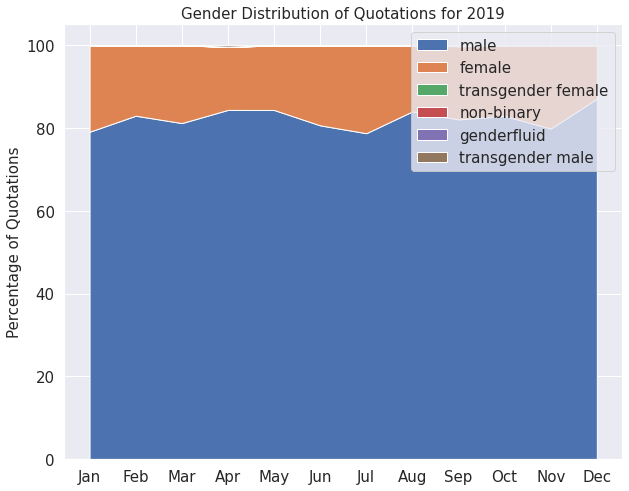

In [67]:
sns.set_theme()

# Plot Percentage
plt.figure(figsize=(10,8))
y_list = [monthly_percent[gender] for gender in monthly_percent]
label_list = [gender for gender in monthly_percent]

plt.stackplot(range(1,13), y_list, labels=(label_list))

months_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.xticks(range(1,13), months_list,fontsize=15)

plt.yticks(fontsize=15)
plt.ylabel('Percentage of Quotations', fontsize=15)
plt.title("Gender Distribution of Quotations for 2019",fontsize=15)
plt.legend(fontsize=15)

## Sentiment Analysis

In [26]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [27]:
#We do the initial sentiment analysis on the first 100000 rows to see if it works
#In M3 the code will be run on full dataset 
prep_pq_sent=prep_pq[:100000]
prep_pq_sent['sentiment_score']=[sia.polarity_scores(i)['compound'] for i in prep_pq_sent['quotation']]

C:\Users\medya\AppData\Local\Temp/ipykernel_15092/356047371.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_pq_sent['sentiment_score']=[sia.polarity_scores(i)['compound'] for i in prep_pq_sent['quotation']]


In [28]:
for gender in ['male', 'female']:
    p_pos=prep_pq_sent[(prep_pq_sent['gender']==gender) & (prep_pq_sent['sentiment_score']>0.4)]['sentiment_score'].count()/len(prep_pq_sent[prep_pq_sent['gender']==gender])
    p_neg=prep_pq_sent[(prep_pq_sent['gender']==gender) & (prep_pq_sent['sentiment_score']<-0.4)]['sentiment_score'].count()/len(prep_pq_sent[prep_pq_sent['gender']==gender])
    p_ntr=prep_pq_sent[(prep_pq_sent['gender']==gender) & (prep_pq_sent['sentiment_score'].between(-0.4, 0.4))]['sentiment_score'].count()/len(prep_pq_sent[prep_pq_sent['gender']==gender])
    s_mean=prep_pq_sent[(prep_pq_sent['gender']==gender)]['sentiment_score'].mean()
    print('Average sentiment score for {g}s is: {s:.4f}'.format(g=gender, s=s_mean))
    print('Percentage of {g}s with positive quotes: {p:.2f}'.format(g=gender, p=100*p_pos))
    print('Percentage of {g}s with negative quotes: {p:.2f}'.format(g=gender, p=100*p_neg))
    print('Percentage of {g}s with neutral quotes: {p:.2f}'.format(g=gender, p=100*p_ntr))

Average sentiment score for males is: 0.1883
Percentage of males with positive quotes: 37.72
Percentage of males with negative quotes: 12.66
Percentage of males with neutral quotes: 49.62
Average sentiment score for females is: 0.1926
Percentage of females with positive quotes: 38.64
Percentage of females with negative quotes: 13.00
Percentage of females with neutral quotes: 48.36


## Thematic Analysis

For this initial analysis, we will only use the sample generated via [HOW AND WHERE WAS IT GENERATED].

Furthermore, for a proper analysis it would be necessary to optimize the hyperparameter `num_topics`. For now we will simply assume `num_topics = 10`, which should give us a good enough place to start but for Phase 3 we will run a GridSearch to determine the optimal value.

Let's start by extracting the tokens for 'male' and 'female' and separate them.

In [8]:
from src.thematic_processing import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2021-11-12 13:16:38,503	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [9]:
tokens_male = prep_pq['tokens'][prep_pq['gender']=='male'].tolist()
tokens_female = prep_pq['tokens'][prep_pq['gender']=='female'].tolist()

In [10]:
# the algorithm used for LDA takes an iterable of strings, so we need to join all the tokens per quote
tokens_male = [' '.join(tokens) for tokens in tokens_male]
tokens_female = [' '.join(tokens) for tokens in tokens_female]

Now that we have the tokens ready, let's train our LDA model

MALE RESULTS
Best Model's Params:  {'n_components': 5, 'learning_decay': 0.7}
Best Log Likelihood Score:  -1389952.7652563087
Model Perplexity:  1879.9305960657432


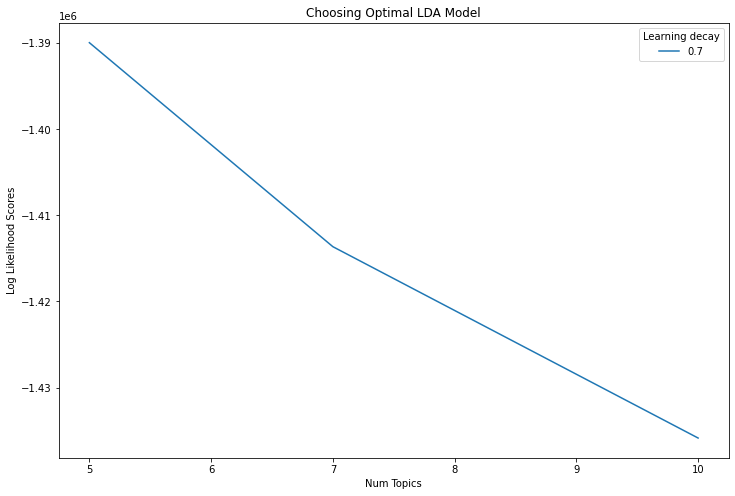


FEMALE RESULTS
Best Model's Params:  {'n_components': 5, 'learning_decay': 0.7}
Best Log Likelihood Score:  -1361645.5576136701
Model Perplexity:  1908.653710701437


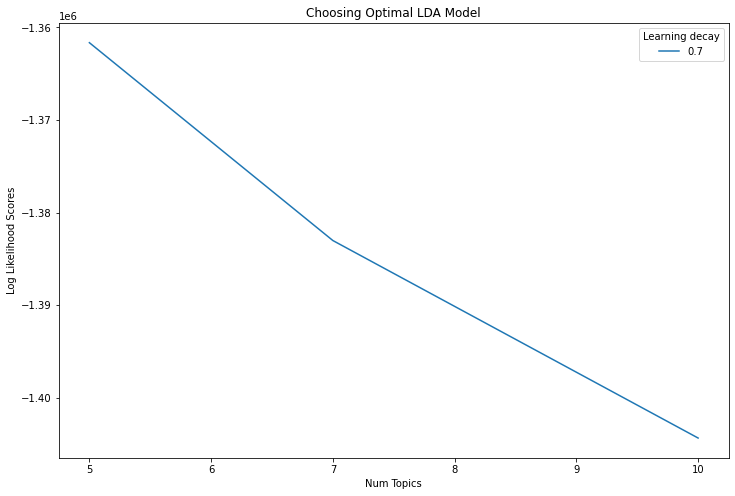

Time: 1992.4s


In [12]:
start = timeit.default_timer()
print('MALE RESULTS')
m_vectorizer, m_docword_matrix, m_best_lda_model = grid_search(tokens_male[:100000]  , [5, 7, 10], [.7], print_res = True, plot_res = True)

print('\nFEMALE RESULTS')
f_vectorizer, f_docword_matrix, f_best_lda_model = grid_search(tokens_female[:100000], [5, 7, 10], [.7], print_res = True, plot_res = True)

stop = timeit.default_timer()
print(f'Time: {stop-start:.1f}s')

Now we can see the topic distribution along our documents

In [13]:
print('MALE TOPIC DISTRIBUTION')
m_df_document_topic, m_df_topic_distribution = topics_docs_matrix(m_best_lda_model, m_docword_matrix, show_dist = True)
print('FEMALE TOPIC DISTRIBUTION')
f_df_document_topic, f_df_topic_distribution = topics_docs_matrix(f_best_lda_model, f_docword_matrix, show_dist = True)

MALE TOPIC DISTRIBUTION


,Topic Num,Num Documents
0,4,36640
1,0,17066
2,3,15985
3,1,15618
4,2,14691


FEMALE TOPIC DISTRIBUTION


,Topic Num,Num Documents
0,2,30296
1,0,23173
2,4,20961
3,3,14546
4,1,11024


And see the intertopic distance, to visually gauge the correctness of the clustering

*NOTE*: See files `LDA_Male.html` and `LDA_Female.html`

In [ ]:
show_intertopic_distance(m_best_lda_model, m_docword_matrix, m_vectorizer, in_IDE = True, output_name = 'LDA_Male.html')
show_intertopic_distance(f_best_lda_model, f_docword_matrix, f_vectorizer, in_IDE = True, output_name = 'LDA_Female.html')

MALE INTERTOPIC DISTANCE


C:\Users\tsfei\anaconda3\envs\ADA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\tsfei\anaconda3\envs\ADA\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\tsfei\anaconda3\envs\ADA\lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:44: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "
C:\Users\tsfei\anaconda3\envs\ADA\lib\site-packages\daal4py\sklearn\manifold\_t_sne.py:60: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.

FEMALE INTERTOPIC DISTANCE


And finally we can see the top words per topic and how the words are distributed in general.

In [15]:
print('DISTRIBUTION OF WORDS IN MALES')
m_df_topic_keywords = get_topics_words(m_best_lda_model, m_vectorizer, show_words = True)
print('MAIN WORDS PER TOPIC IN MALES')
m_df_top_words = get_top_words_per_topic(m_best_lda_model, m_vectorizer, n_words = 15)
display(m_df_top_words)

print('\nDISTRIBUTION OF WORDS IN FEMALES')
f_df_topic_keywords = get_topics_words(f_best_lda_model, f_vectorizer, show_words = True)
print('MAIN WORDS PER TOPIC IN FEMALES')
f_df_top_words = get_top_words_per_topic(f_best_lda_model, f_vectorizer, n_words = 15)
display(f_df_top_words)

DISTRIBUTION OF WORDS IN MALES


C:\Users\tsfei\anaconda3\envs\ADA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aap,abandon,abide,ability,able,aboriginal,abortion,abroad,absence,absent,...,young,youngster,youth,youtube,zealand,zealander,zip,zone,zoo,zoom
Topic0,0.203720,0.202570,17.702966,83.221477,281.663034,2.318722,25.291869,42.186511,7.428515,5.752173,...,0.777017,0.200278,3.269106,0.200453,3.703503,14.378093,0.201262,5.812504,0.201553,0.202929
Topic1,1.759402,29.709898,6.735322,65.674097,343.272112,13.075446,13.325511,0.794944,0.202922,0.203608,...,130.968444,0.202335,7.395986,0.999355,0.200509,9.015282,6.893062,37.716536,14.184315,21.636245
Topic2,0.201310,0.637694,3.058322,211.556311,153.073699,0.202330,6.977160,0.203893,10.932891,0.202643,...,194.749571,0.204196,111.622610,33.945856,0.204244,0.202983,0.201763,19.011032,0.201889,2.812136
Topic3,22.635397,25.248127,16.301782,3.225027,260.687594,0.201845,0.205106,23.500494,22.233604,8.640261,...,0.251983,0.201215,48.127417,0.200844,7.344422,0.200574,0.203427,27.332076,0.205089,0.202690
Topic4,0.200171,0.201711,0.201607,163.323088,940.303561,0.201657,0.200354,2.314158,0.202069,0.201316,...,665.252985,25.191975,1.584882,0.653492,2.547323,0.203067,4.500486,105.127852,0.207154,9.146000


MAIN WORDS PER TOPIC IN MALES


C:\Users\tsfei\anaconda3\envs\ADA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,need,health,people,public,community,care,government,work,home,help,service,area,covid,virus,use
Topic 1,people,make,time,way,life,know,school,test,come,mean,live,say,lot,thing,need
Topic 2,year,new,country,world,market,change,think,experience,great,growth,lead,woman,grow,technology,product
Topic 3,work,make,support,government,continue,want,look,come,time,day,business,decision,state,forward,thank
Topic 4,think,good,really,know,play,want,thing,time,come,game,say,make,year,lot,team



DISTRIBUTION OF WORDS IN FEMALES


C:\Users\tsfei\anaconda3\envs\ADA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abandon,abhorrent,abide,ability,able,abolish,aboriginal,abortion,abroad,absence,...,youa,young,youngster,youth,youtube,zealand,zealander,zombie,zone,zoom
Topic0,0.205187,3.975750,0.201325,91.593800,580.841772,0.201929,0.201927,0.202167,0.201640,0.202973,...,17.192228,1259.333870,6.553035,92.674236,1.149666,0.200749,0.201741,0.202994,66.155189,6.253149
Topic1,12.245968,0.200103,0.202598,63.963384,90.888861,0.204353,0.204286,0.200649,0.202676,7.816354,...,0.200056,0.201742,0.202404,32.646370,0.201704,0.201187,25.776922,0.202012,16.126389,11.974100
Topic2,0.299568,2.340030,0.200734,37.268700,659.700018,0.200221,0.209907,0.200476,0.204306,3.962926,...,0.207157,1.596864,15.836959,0.245380,40.923574,0.202541,0.208932,11.191734,16.292692,0.207400
Topic3,49.335397,0.241462,0.208281,27.364788,46.132224,13.544769,21.731156,222.618420,29.541923,25.995953,...,0.200013,2.730884,0.202978,21.127218,2.416575,0.203692,0.203689,0.201333,0.505407,0.201062
Topic4,3.913880,14.242655,40.187062,173.809328,551.437126,1.848728,5.652724,0.778288,31.849455,8.021795,...,0.200546,30.136640,0.204623,51.306796,2.308481,19.191831,21.608717,0.201926,12.920323,1.364289


MAIN WORDS PER TOPIC IN FEMALES


C:\Users\tsfei\anaconda3\envs\ADA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,think,people,want,know,woman,come,say,thing,talk,make,time,way,year,tell,lot
Topic 1,new,make,use,change,food,time,high,water,drive,way,product,eat,year,level,good
Topic 2,really,love,feel,good,time,make,say,think,know,work,day,thing,look,lot,come
Topic 3,people,make,life,right,child,money,live,school,country,issue,pay,government,state,try,stand
Topic 4,need,work,community,people,health,support,help,government,business,make,continue,care,provide,public,service
